# Data Analysis

In this notebook I am performing data analysis on the scraped data for job listings.

### Table of contents

1. [Libraries and dataset](#Libraries-and-dataset)

2. [Initial Data Exploration](#Initial-Data-Exploration)
  1. [Visualizing the categorical data](#Visualizing-the-categorical-data)
  2. [Plotting word frequencies](#Plotting-word-frequencies)
  
3. [Text Pre-Processing](#Text-Pre-Processing)
  1. [Convert all text to lower case](#Convert-all-text-to-lower-case)
  2. [Remove special characters, unnecessary punctuation and digits](#Remove-special-characters,-unnecessary-punctuation-and-digits)
  3. [Tokenize and remove stop words](#Tokenize-and-remove-stop-words)
  4. [Lemmatize the description words](#Lemmatize-the-description-words)
  
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  1. [Wordcloud visualizations](#Wordcloud-visualizations)
  2. [Visualizing n-gram distributions](#Visualizing-n-gram-distributions)
  
5. [Conclusion](#Conclusion)

## Libraries and dataset

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
%matplotlib inline
sns.set_theme()                    # Allows seaborn to handle the plotting theme

Let's load our database.

In [3]:
from modeling.database import MongoDB
db = MongoDB()

## Initial Data Exploration

Firstly, let's retrieve all documents.

In [4]:
documents = db.get_all_documents()
df = pd.DataFrame(list(documents))

Here we delete the `id` and `url` columns as they are not useful for our data analysis.

Then we modify the `roles` column to only show the first role available as a singular record instead of a list.

The reason is that some job titles may have matched multiple roles, and therefore we keep the first one matched.

In [5]:
df.drop(df.columns[range(0,3)], axis=1, inplace=True)
df.drop('last_accessed', axis=1, inplace=True)
df['roles'] = df['roles'].apply(lambda x: x[0] if isinstance(x, list) else x)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   roles        337 non-null    object
 1   company      246 non-null    object
 2   location     337 non-null    object
 3   type         270 non-null    object
 4   industry     177 non-null    object
 5   workplace    165 non-null    object
 6   description  337 non-null    object
 7   level        137 non-null    object
dtypes: object(8)
memory usage: 21.2+ KB


Let's see how out dataset currently looks like.

In [6]:
df.head()

,roles,company,location,type,industry,workplace,description,level
0,Data Scientist,Incelligent,"Nea Smyrni, Attiki, Greece",Full-time,Telecommunications,On-site,We are looking for a bright Machine Learning E...,NaN
1,Data Scientist,Dyania Health,"Athens, Attiki, Greece",Full-time,Hospitals and Health Care,On-site,Role Description:\n\nAs a multidisciplinary te...,NaN
2,Data Scientist,Intracom Telecom,"Paiania, Attiki, Greece",Full-time,Telecommunications,On-site,INTRACOM TELECOM is a global telecommunication...,NaN
3,Data Scientist,Quintessential SFT,"Athens, Attiki, Greece",Full-time,Software Development,Remote,The continuous development of Web and Mobile a...,NaN
4,Data Scientist,Baresquare,Thessaloniki Metropolitan Area,Full-time,IT Services and IT Consulting,On-site,About Us\n\nBaresquare is changing the world o...,NaN


We see that some of the data contain missing values. Let's explore the degree of such missing data in our dataset.

In [7]:
df.isnull().sum()

roles            0
company         91
location         0
type            67
industry       160
workplace      172
description      0
level          200
dtype: int64

Indeed, some of the columns contains significant amount of missing data. We will have to deal with this issue.

### Visualizing the categorical data

Let's begin by finding the distribution in the category columns of `roles` and `industry`.

In [8]:
df_role_count = df['roles'].value_counts()
df_role_count

Data Engineer     143
Data Scientist     89
Data Analyst       68
ML Engineer        37
Name: roles, dtype: int64

<AxesSubplot: >

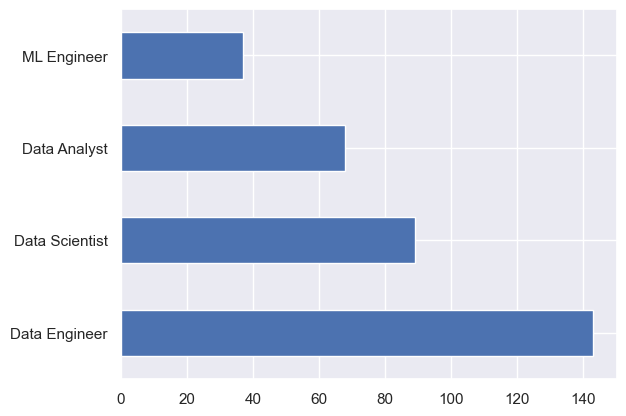

In [9]:
df_role_count.plot.barh()

In [10]:
df_industry_count = df['industry'].value_counts()
df_industry_count

IT Services and IT Consulting           38
Accounting                              17
IT                                      15
Software Development                    14
Telecommunications                      13
Pharmaceutical Manufacturing            11
Technology, Information and Internet     9
Business Consulting and Services         8
Staffing and Recruiting                  5
Financial Services                       5
Research Services                        5
BI / Business Analysis                   4
Entertainment Providers                  4
Automation Machinery Manufacturing       4
Professional Services                    3
Retail                                   2
Market Research                          2
Oil and Gas                              2
Advertising Services                     2
General Management                       1
Manufacturing                            1
Finance                                  1
Other                                    1
Tobacco Man

We can see that the different websites name their industry categories differently. We can group them in a more concise way.

In [11]:
df['industry'] = df['industry'].apply(lambda x: 'IT Services and IT Consulting' if x == 'IT' else x)
df['industry'] = df['industry'].apply(lambda x: 'Business Consulting and Services' if x == 'BI / Business Analysis' else x)
df['industry'] = df['industry'].apply(lambda x: 'Market Research' if x == 'Marketing / Advertising' else x)
df['industry'] = df['industry'].apply(lambda x: 'Financial Services' if x == 'Finance' else x)
df['industry'] = df['industry'].apply(lambda x: 'Manufacturing' if 'manufacturing' in str(x).lower() else x)

Plot the top 10 industry types that we found in the dataset.

<AxesSubplot: >

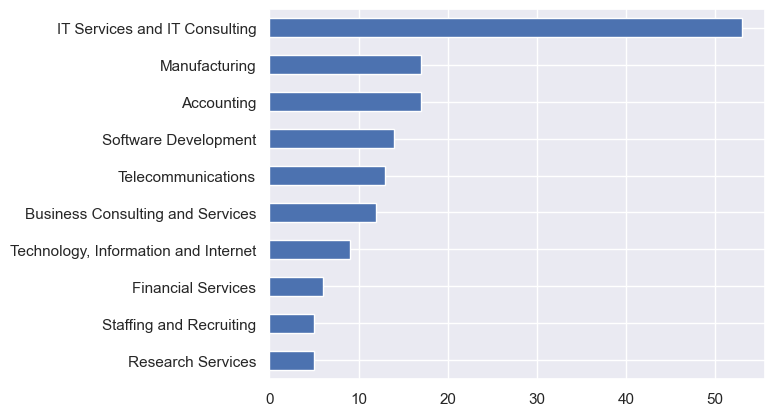

In [12]:
df_industry_count = df['industry'].value_counts()
df_industry_count.sort_values(ascending=True, inplace=True)
df_industry_count.tail(10).plot.barh()

Next we will see the columns describing the `workplace` and the `level`. We also unify the results from all websites.

In [13]:
df_work_count = df['workplace'].value_counts()
df_work_count

On-site               78
Hybrid                49
Remote                28
Part remote            8
Temporarily remote     1
Full remote            1
Name: workplace, dtype: int64

In [14]:
df['workplace'] = df['workplace'].apply(lambda x: 'Hybrid' if x=='Part remote' else x)
df['workplace'] = df['workplace'].apply(lambda x: 'Remote' if (x=='Temporarily remote' or x=="Full remote") else x)
df_work_count = df['workplace'].value_counts()

Notice that the `level` column has the most **null** values, which we will probably drop later on.

In [15]:
df_level_count = df['level'].value_counts()
df_level_count

Mid-Senior level    53
Entry level         36
Associate           21
Mid level           16
Senior               5
Internship           2
Entry/Junior         2
Executive            1
Full-time            1
Name: level, dtype: int64

In [16]:
df['level'] = df['level'].apply(lambda x: 'Entry level' if x=='Entry/Junior' else x)
df['level'] = df['level'].apply(lambda x: 'Mid-Senior level' if (x=='Mid level' or x=='Senior' or x=='Full-time') else x)
df_level_count = df['level'].value_counts()

Let's create some pie charts to showcase the distribution of these two columns (`workplace`, `level`).

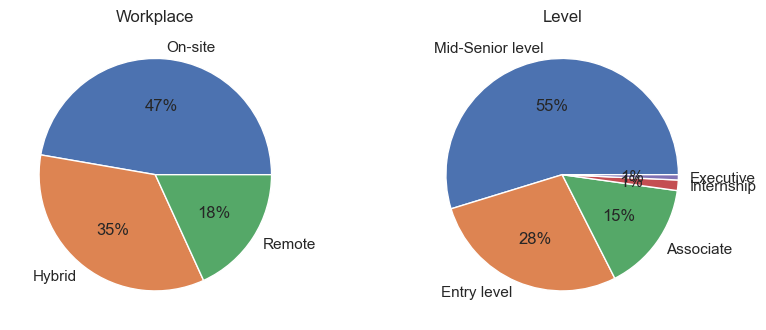

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
plt.subplots_adjust(wspace=0.4)

axes[0].pie(df_work_count, labels=df_work_count.index, autopct='%.0f%%')
axes[0].set_title("Workplace")

axes[1].pie(df_level_count, labels=df_level_count.index, autopct='%.0f%%')
axes[1].set_title("Level")

plt.show()

### Plotting word frequencies

First, I show the 20 most common words in the whole corpus.

<AxesSubplot: xlabel='word'>

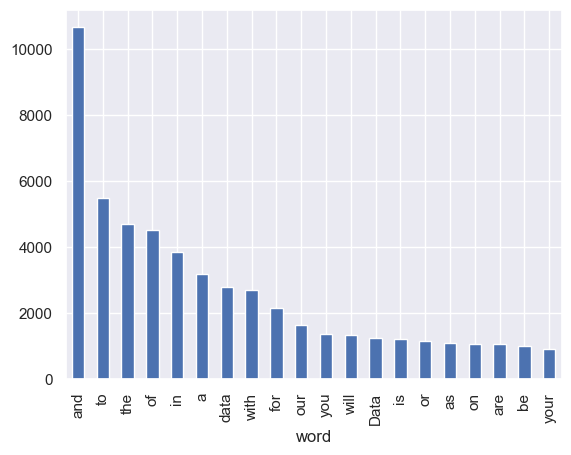

In [18]:
from collections import Counter
corpus_ct = Counter(" ".join(df["description"]).split()).most_common(20)
df_corpus = pd.DataFrame.from_dict(corpus_ct)
df_corpus = df_corpus.rename(columns={0: "word", 1: "count"})

df_corpus.plot.bar(x='word', y='count', legend=False)

Let's break it down to the 20 most common words in each `role` category.

In [19]:
ds_ct    = Counter(" ".join(df[df['roles']=='Data Scientist']["description"]).split()).most_common(20)
ai_ct    = Counter(" ".join(df[df['roles']=='Data Analyst']["description"]).split()).most_common(20)
ml_ct    = Counter(" ".join(df[df['roles']=='ML Engineer']["description"]).split()).most_common(20)
mlops_ct = Counter(" ".join(df[df['roles']=='Data Engineer']["description"]).split()).most_common(20)

In [20]:
df_ds = pd.DataFrame.from_dict(ds_ct)
df_ds = df_ds.rename(columns={0: "word", 1: "count"})

df_ai = pd.DataFrame.from_dict(ai_ct)
df_ai = df_ai.rename(columns={0: "word", 1: "count"})

df_ml = pd.DataFrame.from_dict(ml_ct)
df_ml = df_ml.rename(columns={0: "word", 1: "count"})

df_mlops = pd.DataFrame.from_dict(mlops_ct)
df_mlops = df_mlops.rename(columns={0: "word", 1: "count"})

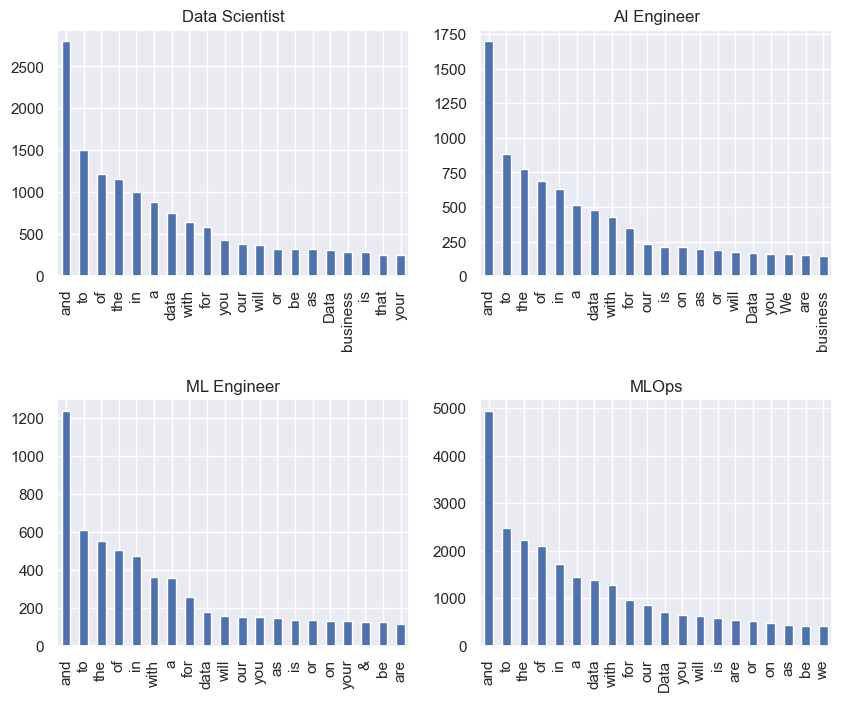

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

df_ds.plot.bar(x='word', y='count', legend=False, ax=axes[0,0])
axes[0,0].set_title('Data Scientist')
axes[0,0].set(xlabel=None)

df_ai.plot.bar(x='word', y='count', legend=False, ax=axes[0,1])
axes[0,1].set_title('AI Engineer')
axes[0,1].set(xlabel=None)

df_ml.plot.bar(x='word', y='count', legend=False, ax=axes[1,0])
axes[1,0].set_title('ML Engineer')
axes[1,0].set(xlabel=None)

df_mlops.plot.bar(x='word', y='count', legend=False, ax=axes[1,1])
axes[1,1].set_title('MLOps')
axes[1,1].set(xlabel=None)

plt.show()

As we can see, the most common words are either *propositions*, *conjuctions* or *pronouns*.

Some entries are also not words but symbols or punctuation.

Later we will try to eliminate those as they should have no influence on the training of our model.

## Text Pre-Processing

This part, called *text pre-processing*, is where we perform various transformations to the raw dataset's fields.

In detail, we will perform the following transformations:

1. [Text cleaning](#Text-cleaning)
2. [Tokenize sentences](#Tokenize-sentences)
3. [POS Tagging](#POS-Tagging)
4. [Remove stop words](#Remove-stop-words)
5. [Normalization](#Normalization)

### Text cleaning

In [22]:
df['description'] = df['description'].apply(lambda x: x.lower())               # Convert to lower case
df['description'] = df['description'].str.replace(r'[^\w\s]', ' ', regex=True) # Remove special characters
df['description'] = df['description'].str.replace(r'\d+', '', regex=True)      # Remove digits
df['description'] = df['description'].str.replace(r'\s*\n+', ' ', regex=True)  # Remove new lines and whitespaces
df['description'].head()

0    we are looking for a bright machine learning e...
1    role description as a multidisciplinary team m...
2    intracom telecom is a global telecommunication...
3    the continuous development of web and mobile a...
4    about us baresquare is changing the world of a...
Name: description, dtype: object

### Tokenize sentences

Tokenization is an important part of NLP as it transforms sentences into smaller units (tokens) that easier to work with.

In our case I am going to use word tokens.

In [23]:
from nltk.tokenize import word_tokenize

df['description'] = df['description'].apply(lambda x: word_tokenize(x))
df['description'].head()

0    [we, are, looking, for, a, bright, machine, le...
1    [role, description, as, a, multidisciplinary, ...
2    [intracom, telecom, is, a, global, telecommuni...
3    [the, continuous, development, of, web, and, m...
4    [about, us, baresquare, is, changing, the, wor...
Name: description, dtype: object

### POS Tagging

Part-of-speech tagging is the process of labeling words in a corpus to indicate a corresponding *part of speech* (e.g noun, verb, adjective etc.), based on its definition and context. After successful tagging, we may be able to understand the distribution of such parts of speech in our dataset.

In [24]:
#nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

df['description'] = df['description'].apply(lambda x: pos_tag(x))
df['description'].head()

0    [(we, PRP), (are, VBP), (looking, VBG), (for, ...
1    [(role, NN), (description, NN), (as, IN), (a, ...
2    [(intracom, NN), (telecom, NN), (is, VBZ), (a,...
3    [(the, DT), (continuous, JJ), (development, NN...
4    [(about, IN), (us, PRP), (baresquare, NN), (is...
Name: description, dtype: object

It will be easier for us to group the different parts of speech if we combine all the tagged tokens.

In [25]:
group = [word for pos_desc in df['description'].tolist() for word in pos_desc]
group_df = pd.DataFrame(group, columns = ('word','pos'))
group_df.head()

,word,pos
0,we,PRP
1,are,VBP
2,looking,VBG
3,for,IN
4,a,DT


In [26]:
group_df['pos'].value_counts().nlargest(5)

NN     52537
NNS    24558
JJ     22931
IN     21390
CC     12327
Name: pos, dtype: int64

Let's see the first 250 words that were categorized as nouns (NN or NNS).

In [27]:
noun_tags = group_df[(group_df['pos']=='NN') | (group_df['pos']=='NNS')]
noun_tags_list = noun_tags['word'].head(250).unique().tolist()

print(', '.join(map(repr, noun_tags_list)))

'machine', 'engineer', 'engineering', 'team', 'athens', 'software', 'solutions', 'corporations', 'transformation', 'usage', 'data', 'ml', 'analytics', 'platform', 'deployment', 'models', 'part', 'domains', 'institutions', 'risk', 'marketing', 'recommendation', 'telecommunications', 'kpi', 'compliance', 'image', 'processing', 'research', 'development', 'activities', 'state', 'art', 'techniques', 'lstm', 'cnn', 'odenet', 'gnn', 'product', 'design', 'learning', 'intelligence', 'algorithms', 'production', 'pipeline', 'datasets', 'patterns', 'insights', 'visualize', 'dataset', 'findings', 'features', 'requirements', 'science', 'statistics', 'fields', 'years', 'experience', 'python', 'scala', 'java', 'sql', 'knowledge', 'preparation', 'correlation', 'analysis', 'hypotheses', 'shallow', 'tasks', 'model', 'performance', 'error', 'kpis', 'hyperparameter', 'cross', 'validation', 'framework', 'networks', 'keras', 'family', 'rnn', 'dbn', 'version', 'control', 'ops', 'adaptation', 'e', 'g', 'flow',

We can see that the desired tools to extract (e.g Python, SQL, etc.) are mostly nouns. This is a good indication for which parts of speech to prioritize.

### Remove stop words

Stop words are called the words that are commonly used (e.g "the", "or", "and", etc.) and they don't provide any valuable context to the corpus. We need to remove those stop words as this process will speed up our processing time and free up space in our dataset. 

In [28]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['description'] = df['description'].apply(lambda x: [word for word in x if word[0] not in stop_words])
df['description'].head()

0    [(looking, VBG), (bright, JJ), (machine, NN), ...
1    [(role, NN), (description, NN), (multidiscipli...
2    [(intracom, NN), (telecom, NN), (global, JJ), ...
3    [(continuous, JJ), (development, NN), (web, NN...
4    [(us, PRP), (baresquare, NN), (changing, VBG),...
Name: description, dtype: object

### Normalization

Normalization of text in a corpus can be achieved by two different methods, namely **Lemmatization** and **Stemming**. Both of these methods aim to reduce the amount of excess information in order to improve efficiency. *Lemmatization* is the process of converting each word to its meaningful base form, which is called a *Lemma*. On the other hand *stemming* is used to analyze the meaning behind a word. While *lemmatization* is preferred for context analysis, *stemming* is recommended when the context is not important or in case of large dataset where performance is an issue.

In [29]:
from nltk.corpus import wordnet

def get_tag_mapping(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

In [30]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

df['description'] = df['description'].apply(lambda x: [wnl.lemmatize(word, get_tag_mapping(tag)) for word, tag in x])
df['description'].head()

0    [look, bright, machine, learn, engineer, join,...
1    [role, description, multidisciplinary, team, m...
2    [intracom, telecom, global, telecommunication,...
3    [continuous, development, web, mobile, applica...
4    [u, baresquare, change, world, analytics, know...
Name: description, dtype: object

Now that we cleaned our dataset, let's observe again the most common words that represent our corpus.

<AxesSubplot: xlabel='word'>

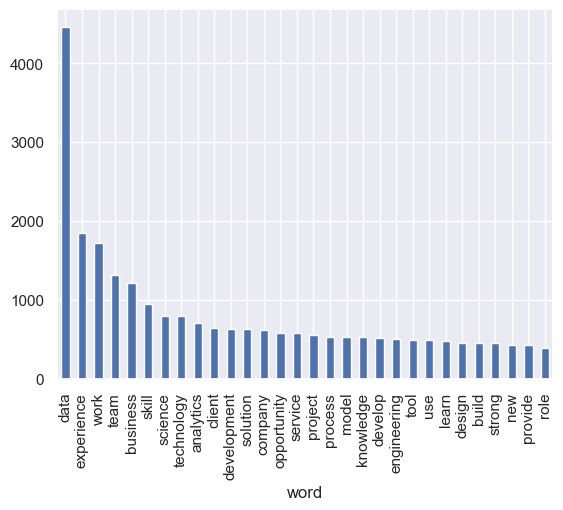

In [31]:
out = df['description'].explode().value_counts().reset_index()[:30]

df_corpus = pd.DataFrame.from_dict(out)
df_corpus = df_corpus.rename(columns={"index": "word", "description": "count"})

df_corpus.plot.bar(x='word', y='count', legend=False)

As seen by the bar plot, our corpus contains more meaningful words than previously. This indicates that we clean the dataset correctly.

### Single character removal

Sometimes, after text cleaning and tagging, there may still exist single character word tokens, for example after cleaning the "e.g." acronym.

Let's attempt to remove such characters from our text.

In [32]:
thrueshold = 1

chars = df['description'].apply(lambda x: [word for word in x if len(word) == thrueshold])
chars.explode().value_counts()

e    343
u    312
g    297
r    160
c     65
b     29
m     20
l     20
k     15
v     13
x      8
f      7
η      5
q      3
z      2
α      2
_      1
d      1
h      1
β      1
ε      1
o      1
Name: description, dtype: int64

In [33]:
df['description'] = df['description'].apply(lambda x: [word for word in x if len(word) > thrueshold])

## Exploratory Data Analysis

Exploratory data analysis (EDA) is used in data science in order to investigate data sets, exploring their main characteristics. It usually involves the usage of visualization methods and graphics in order to make it easier for data scientists to discover patterns, anomalies and check assumptions.

### Wordcloud visualizations

Wordcloud is a concise way to represent text data where the size and color of each word that appears, indicate it’s frequency in the corpus. We are going to use the `wordcloud` package to visualize and show the most common tokens in each role.

First, let's check the unique roles we can find in the preprocessed dataset and then append all tokens to each respective role.

In [34]:
# Keep only the columns that we care for, roles and description
df = df[["roles", "description"]]

# Put description tokens into a single list based on the role they were found in
role_descs = df.groupby(["roles"]).sum().reset_index()
role_descs.head()

,roles,description
0,Data Analyst,"[slashdata, lead, research, company, developer..."
1,Data Engineer,"[job, risk, control, team, business, service, ..."
2,Data Scientist,"[look, bright, machine, learn, engineer, join,..."
3,ML Engineer,"[intracom, telecom, global, telecommunication,..."


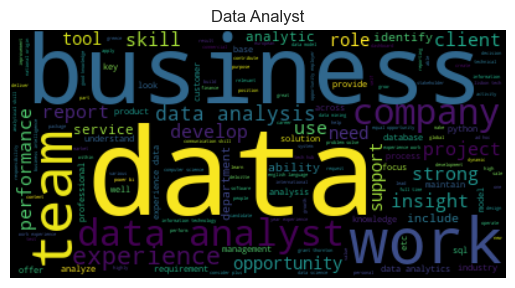

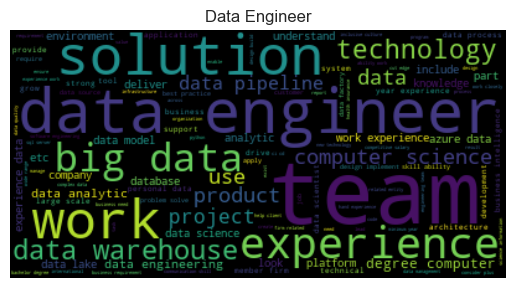

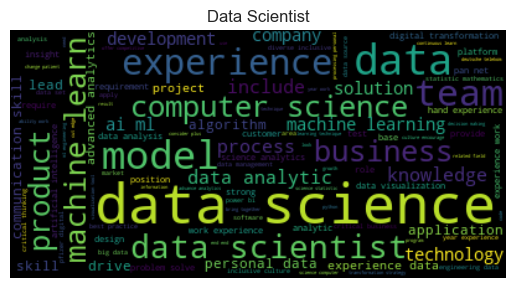

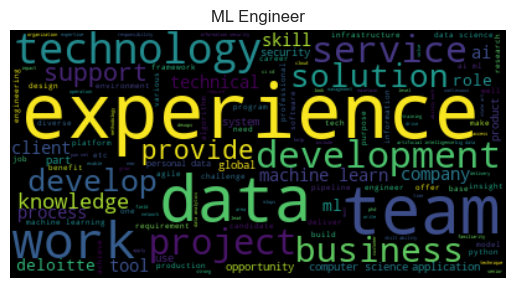

In [35]:
from wordcloud import WordCloud

role_list = role_descs['roles'].unique().tolist()

for role in role_list:
    # Get all tokens for the active job role
    tokens = role_descs[role_descs['roles'] == role].iloc[0].description

    # Generate a word cloud image from said tokens
    wordcloud = WordCloud().generate_from_text(' '.join(tokens))

    # Display wordcloud graphic
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(role)
    plt.show()

As shown in the wordclouds, we did a good job cleaning the dataset as each role is described by very closely assosiated words.

### Visualizing n-gram distributions

In essence, the term *n-grams* refers to the sequence of N words or characters. The naming convention starts with unigram, bigrams, trigrams and n-grams.

Let's compute the bi-grams and tri-grams of the entire corpus and then identify them for each role. As you can imagine the unigram computation will just yield our most common words we saw earlier.

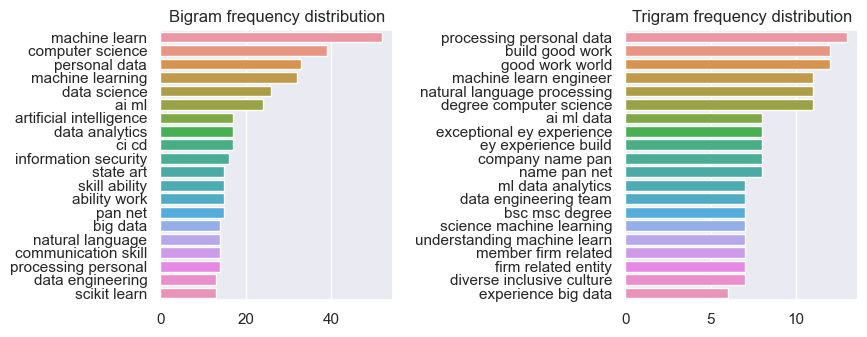

In [36]:
from nltk import FreqDist
from nltk.util import ngrams

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
plt.subplots_adjust(wspace=1, hspace=0.4)

bi_gram          = ngrams(tokens, 2)
bi_gram_dist     = FreqDist(bi_gram).most_common(20)
bi_gram_joined   = {' '.join(k):v for k,v in sorted(bi_gram_dist, key=lambda item:item[1], reverse=True)}
bi_gram_freqdist = pd.Series(bi_gram_joined)

tri_gram          = ngrams(tokens, 3)
tri_gram_dist     = FreqDist(tri_gram).most_common(20)
tri_gram_joined   = {' '.join(k):v for k,v in sorted(tri_gram_dist, key=lambda item:item[1], reverse=True)}
tri_gram_freqdist = pd.Series(tri_gram_joined)

bg = sns.barplot(x=bi_gram_freqdist.values, y=bi_gram_freqdist.index, orient='h', ax=axes[0])
axes[0].set_title(f'Bigram frequency distribution')

tg = sns.barplot(x=tri_gram_freqdist.values, y=tri_gram_freqdist.index, orient='h', ax=axes[1])
axes[1].set_title(f'Trigram frequency distribution')

plt.show()

Let's now compute bigrams and trigrams for each individual role in the data set and compare them.

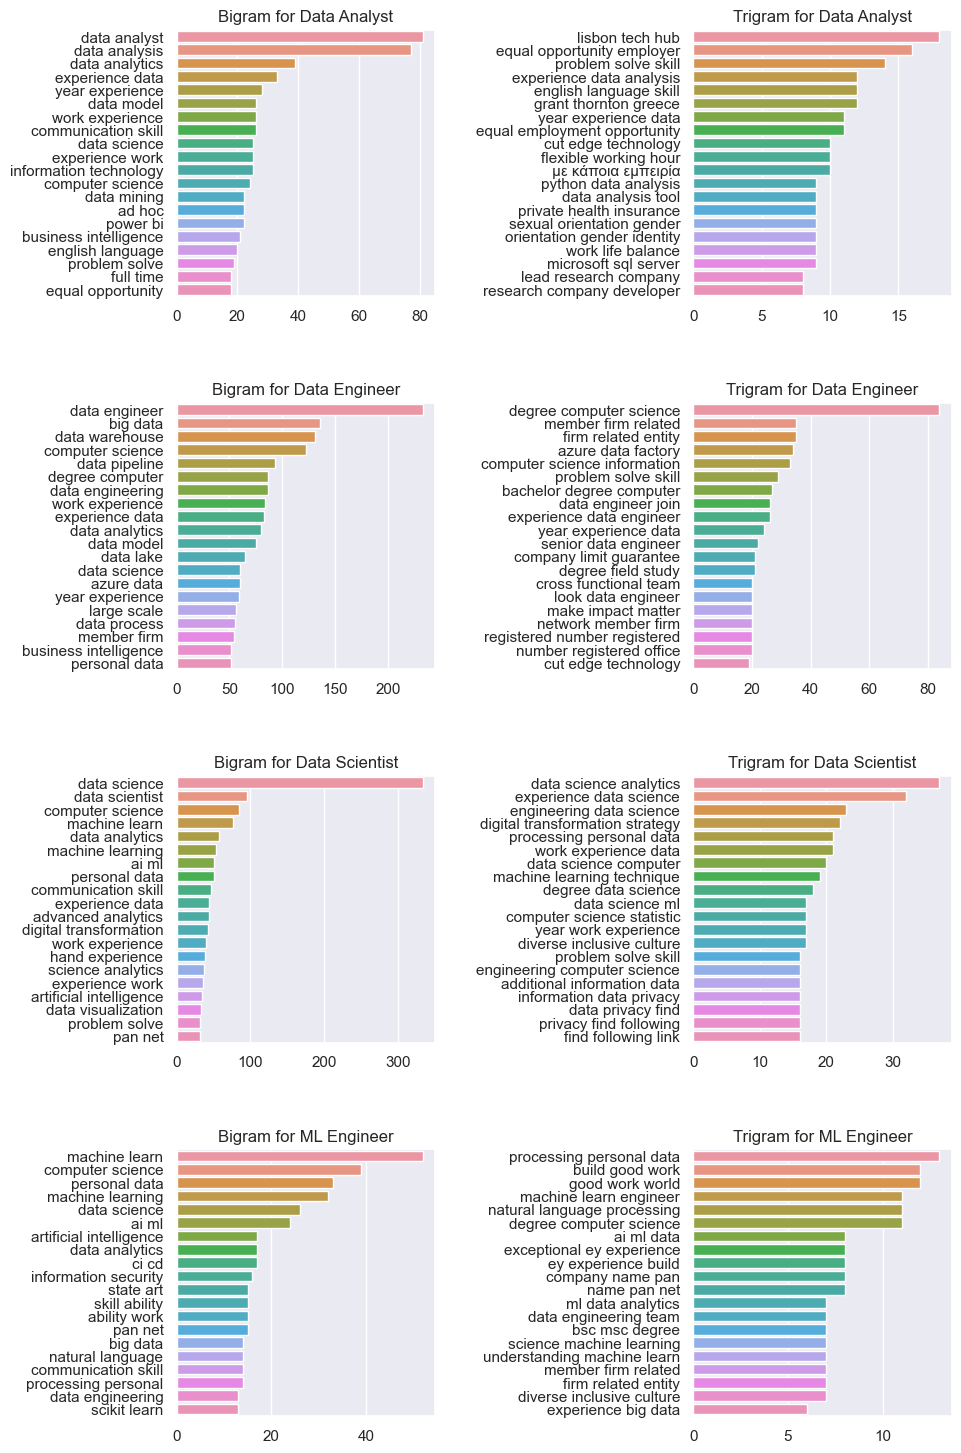

In [37]:
from nltk import FreqDist
from nltk.util import ngrams  

fig, axes = plt.subplots(4, 2, figsize=(10, 18))
plt.subplots_adjust(wspace=1, hspace=0.4)

index = 0
for role in role_list:
    tokens = role_descs[role_descs['roles'] == role].iloc[0].description

    bi_grams = ngrams(tokens, 2)
    tri_grams = ngrams(tokens, 3)
    
    bi_gram_dist = FreqDist(bi_grams).most_common(20)
    tri_gram_dist = FreqDist(tri_grams).most_common(20)

    ## Join bigram tokens with '_' + maintain sorting
    bi_gram_joined = {' '.join(k):v for k,v in sorted(bi_gram_dist, key=lambda item:item[1], reverse=True)}
    tri_gram_joined = {' '.join(k):v for k,v in sorted(tri_gram_dist, key=lambda item:item[1], reverse=True)}

    ## Convert to Pandas series for easy plotting
    bi_gram_freqdist = pd.Series(bi_gram_joined)
    tri_gram_freqdist = pd.Series(tri_gram_joined)
    
    ## Plotting
    bp1 = sns.barplot(x=bi_gram_freqdist.values, y=bi_gram_freqdist.index, orient='h', ax=axes[index, 0])
    axes[index,0].set_title(f'Bigram for {role}')
    
    bp2 = sns.barplot(x=tri_gram_freqdist.values, y=tri_gram_freqdist.index, orient='h', ax=axes[index, 1])
    axes[index,1].set_title(f'Trigram for {role}')
    
    index += 1
    
plt.show()

## Conclusion

In this notebook I performed an initial exploration of the scraped data set. I identified the rate of missing (null) values as well as visualizing the different categorical data and word frequencies. Next, I performed text pre-processing in which I carried out various transformations in the data set in order to improve the quality by eliminating any uneccesary context. This allowed me to identify that skills are mostly in the form of nouns and also allowed for a better and cleaner data set as indicated by wordcloud plots. Lastly I created bar plots that showcase the extracted bigrams and trigrams. These plots show the most common phrases that are closely related with each role.